In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [12]:
df=pd.read_csv('AEP_hourly.csv')
df.head()
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)
df.shape

(145366, 1)

# Data Cleaning
- Handling Missing values
- Handling Duplicates
- Check data type
- Understand the dataset

In [13]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')
print(features_with_na)




[]


In [14]:
df.duplicated().sum()

np.int64(116925)

# TRAIN/TEST SPLIT

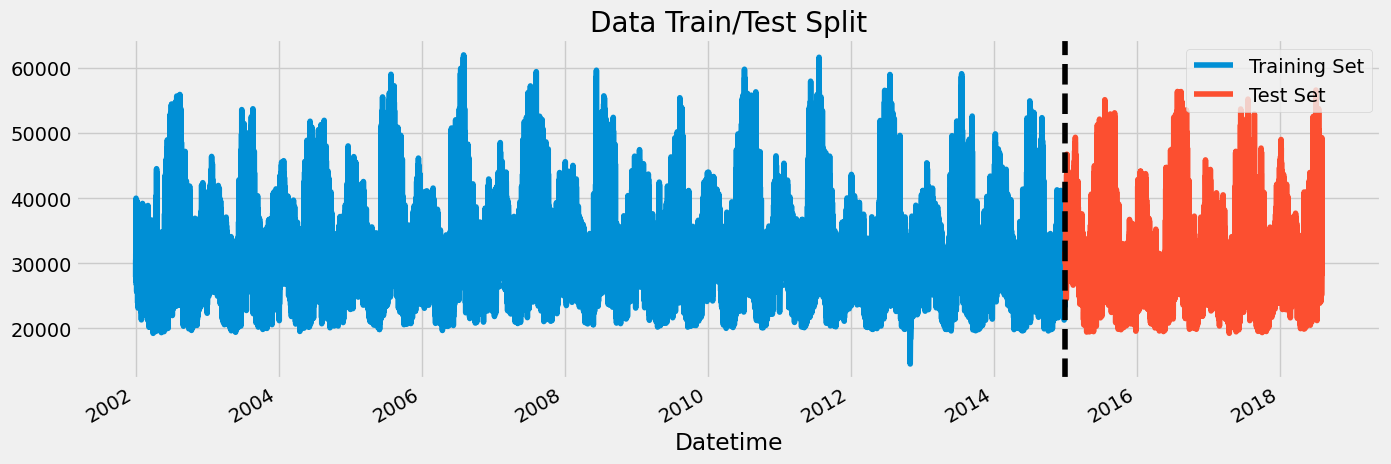

In [15]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# FEATURE CREATION


In [16]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

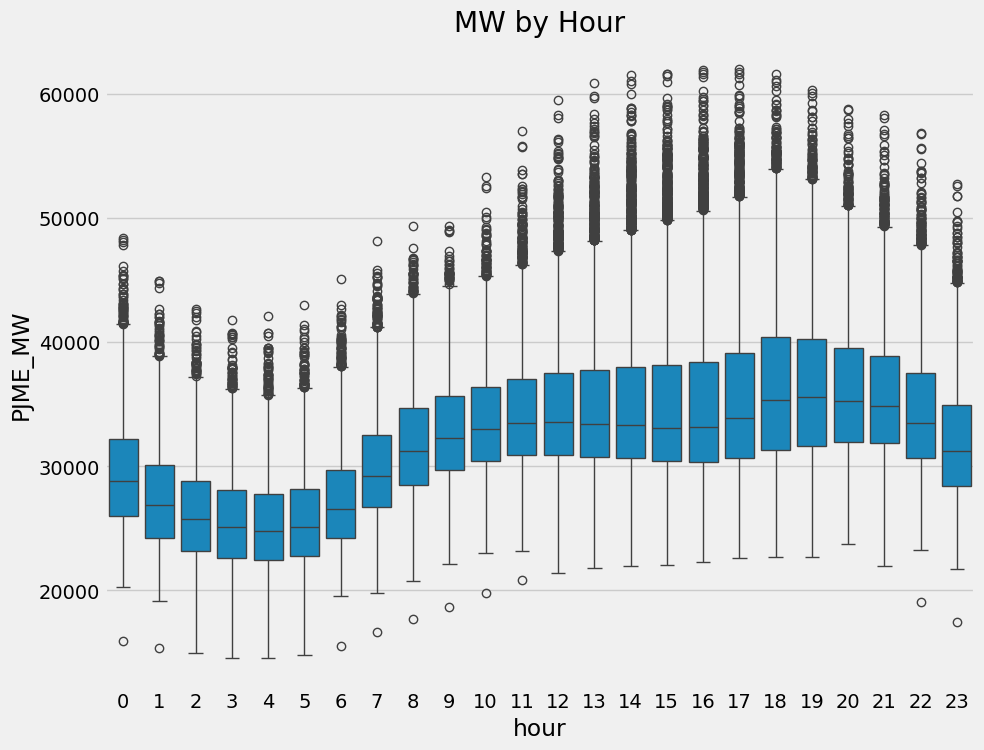

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\prakh\AppData\Local\Temp\ipykernel_24940\2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


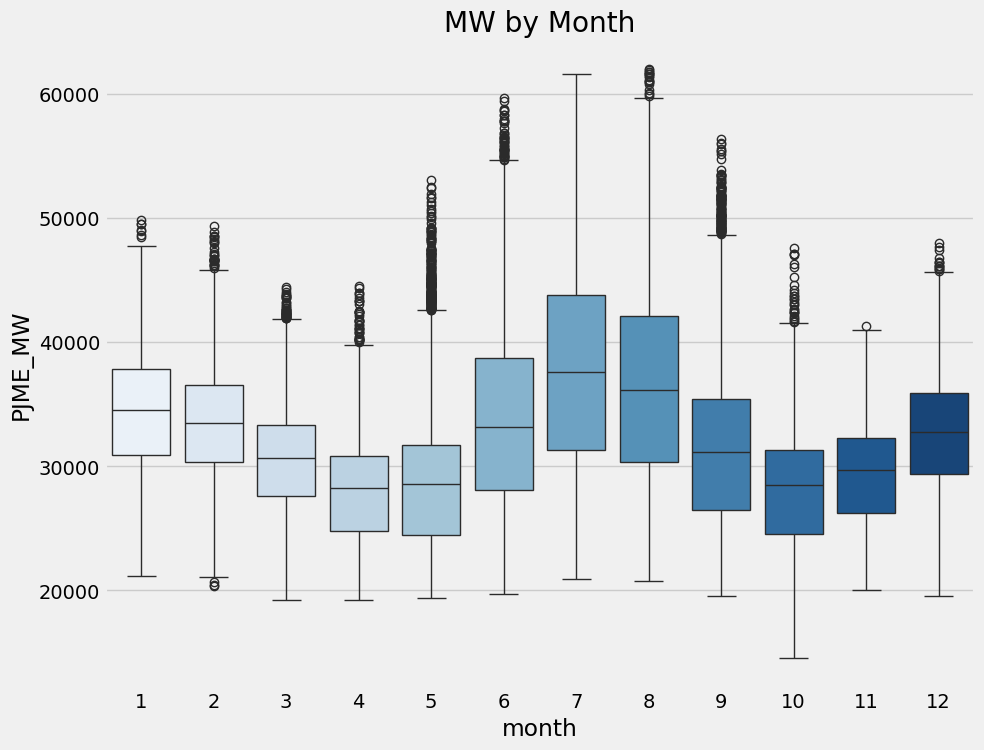

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# CREATE OUR MODEL

In [19]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:44:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# FEATURE IMPORTANCE

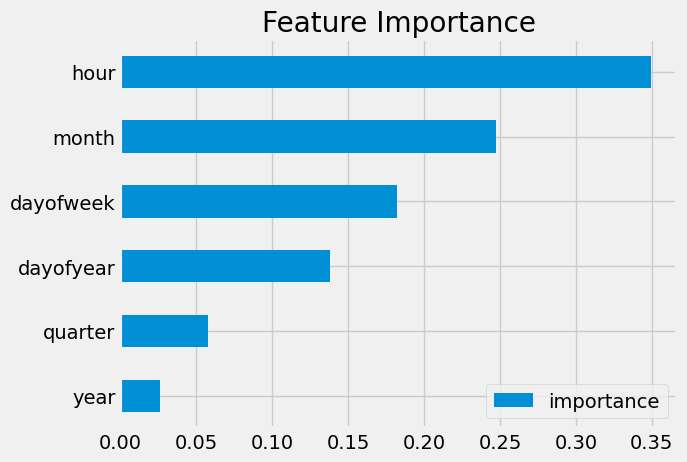

In [21]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# FORECAST ON TEST

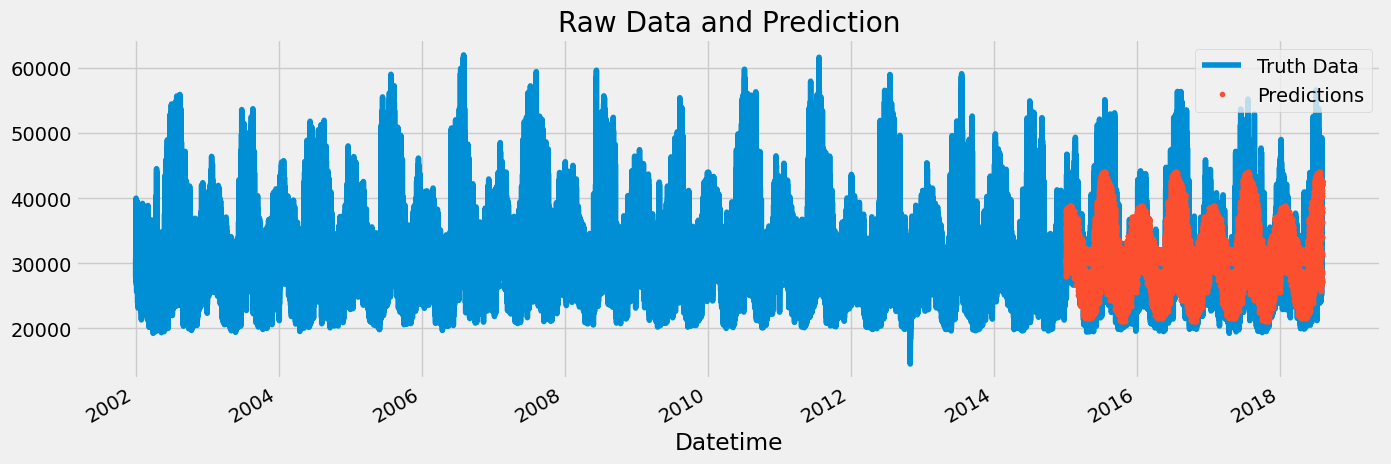

In [22]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

# SCORE (RMSE)

In [24]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


# CALCULATE ERROR

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5630.352132
2015-02-20    5394.673665
2018-01-06    4823.354574
2015-01-08    4703.830404
2015-12-25    4415.192912
2015-02-16    4411.147461
2015-12-24    4138.202759
2015-02-15    4079.741536
2018-01-05    4044.314657
2018-01-07    4037.638062
Name: error, dtype: float64

# OUTLINE
- outlier analysis
- forecasting horizon
- Time series cross validation
- Lag features
- Predicting the future

<Axes: ylabel='Frequency'>

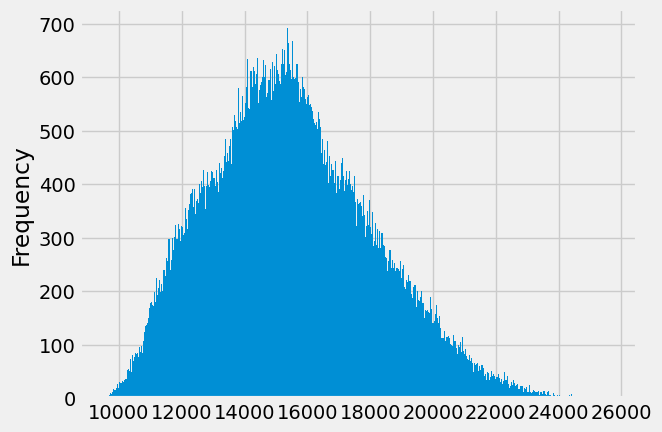

In [ ]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

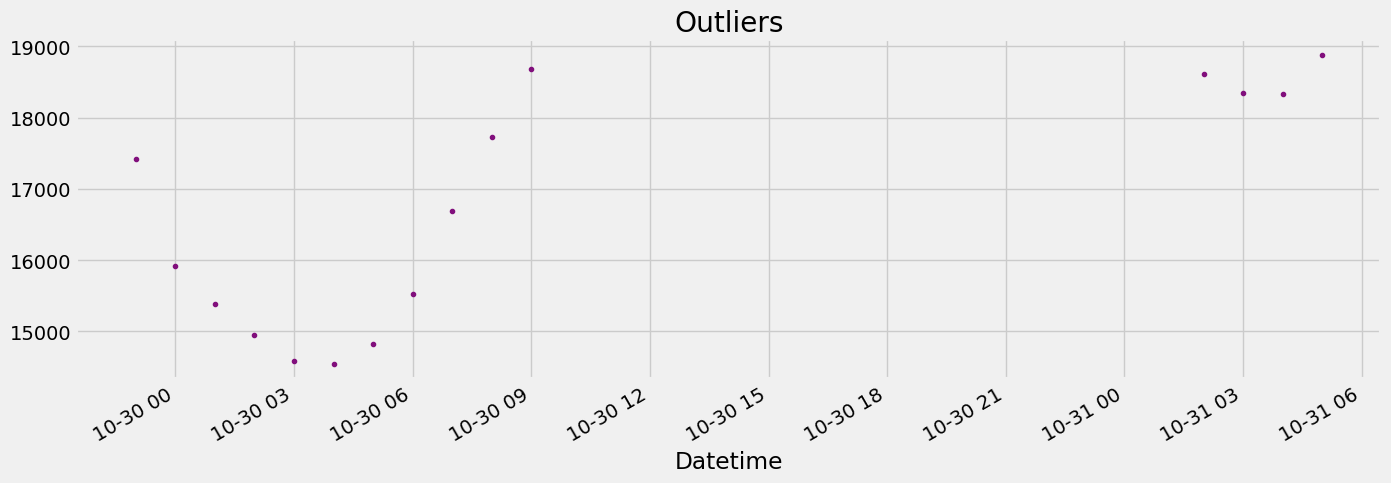

In [27]:
df.query('PJME_MW <19000')['PJME_MW'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [28]:
df = df.query('PJME_MW > 19_000').copy()

# REVIEWING TRAIN/ TEST SPLIT 

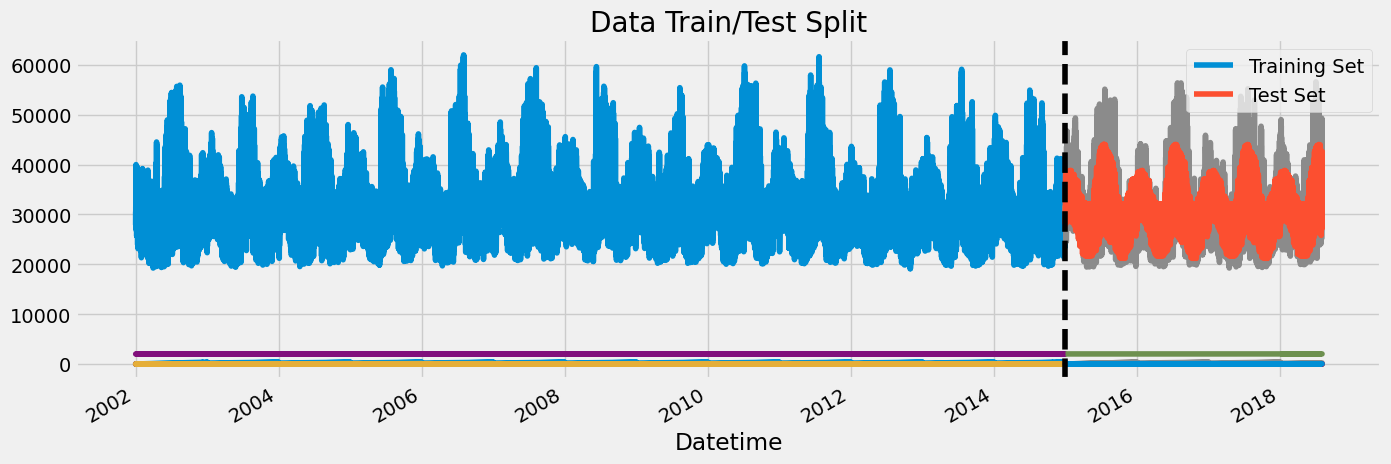

In [29]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. TIME SERIES CROSS VALIDATION 

In [30]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

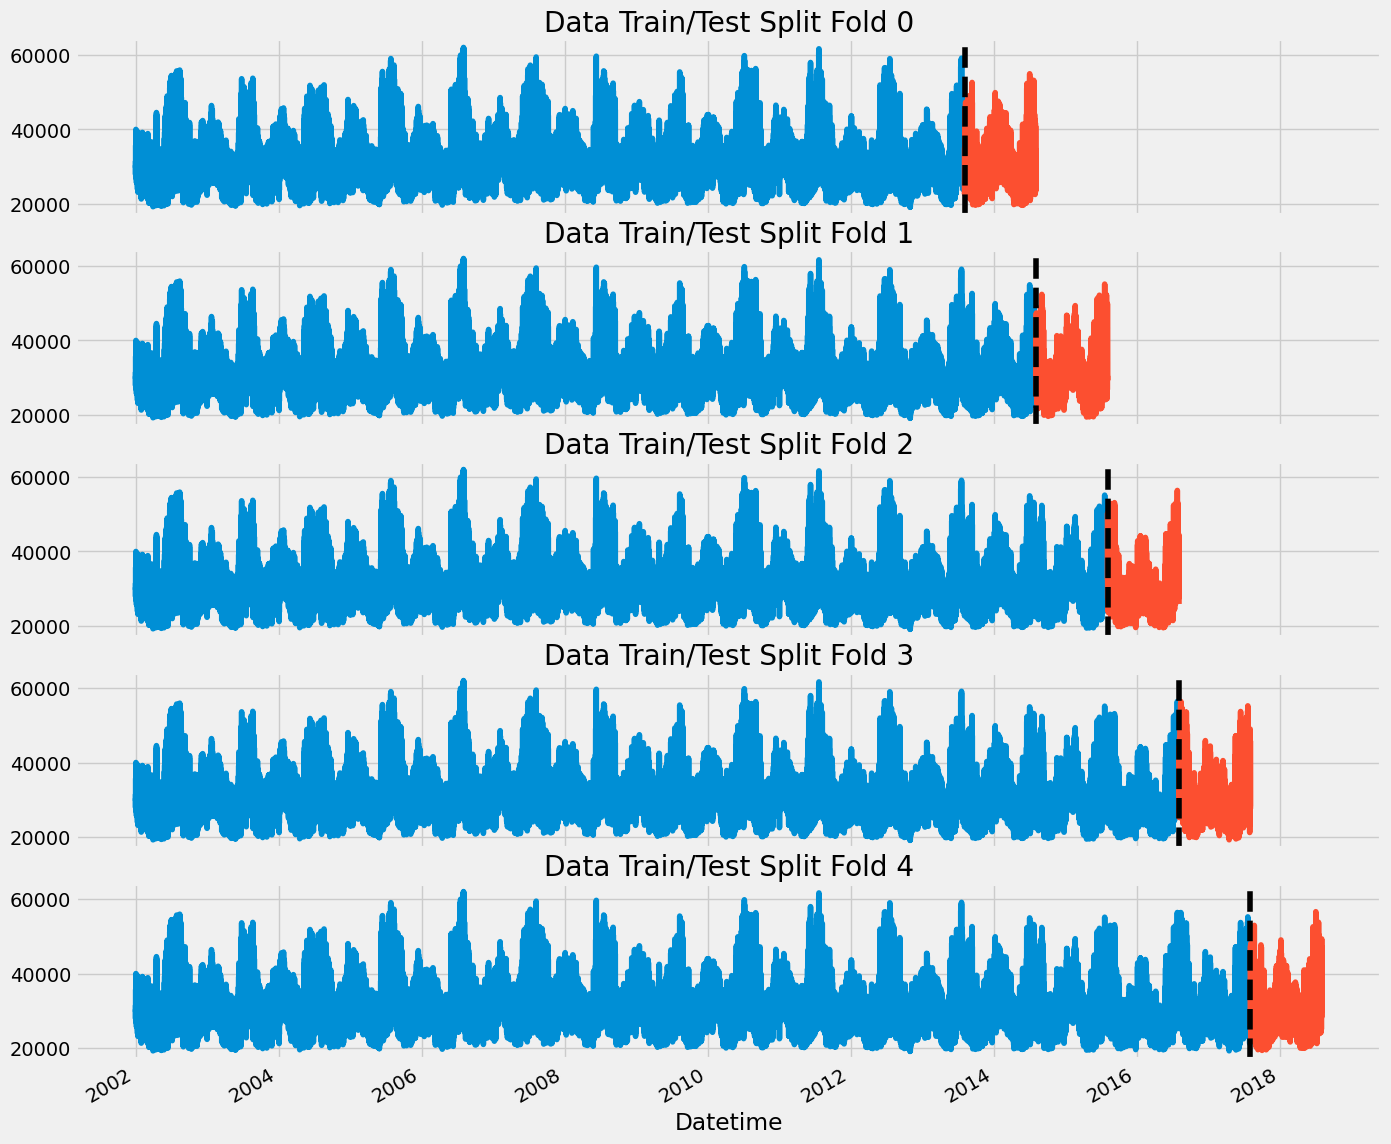

In [31]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. FORECASTING HORIZON  

In [32]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. LAG FEATURES

In [33]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [36]:
df = add_lags(df)
df.tail(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2018-08-02 15:00:00,47154.0,15,3,3,8,2018,214,2,31,42111.214844,46462.0,42631.0,41414.0
2018-08-02 16:00:00,46989.0,16,3,3,8,2018,214,2,31,42152.097656,47318.0,43575.0,41956.0
2018-08-02 17:00:00,46816.0,17,3,3,8,2018,214,2,31,42475.140625,47490.0,44267.0,41920.0
2018-08-02 18:00:00,46760.0,18,3,3,8,2018,214,2,31,42575.265625,46436.0,44460.0,41430.0
2018-08-02 19:00:00,45641.0,19,3,3,8,2018,214,2,31,42575.265625,44429.0,43375.0,39990.0
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42575.265625,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42522.703125,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40804.101562,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,37933.539062,36490.0,35406.0,34552.0


# Training using cross validation

In [37]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:49:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12532.43235	validation_1-rmse:11904.58782
[200]	validation_0-rmse:5744.95222	validation_1-rmse:5356.84300
[300]	validation_0-rmse:3871.90369	validation_1-rmse:3892.59716
[400]	validation_0-rmse:3435.02956	validation_1-rmse:3754.33238
[446]	validation_0-rmse:3364.90600	validation_1-rmse:3757.53894
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:49:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12513.53851	validation_1-rmse:12226.39459
[200]	validation_0-rmse:5755.01846	validation_1-rmse:5651.27874
[300]	validation_0-rmse:3906.82210	validation_1-rmse:3927.45255
[400]	validation_0-rmse:3478.17872	validation_1-rmse:3596.84442
[500]	validation_0-rmse:3352.66618	validation_1-rmse:3523.07822
[600]	validation_0-rmse:3296.70510	validation_1-rmse:3487.82916
[700]	validation_0-rmse:3257.73321	validation_1-rmse:3468.06020
[800]	validation_0-rmse:3222.25681	validation_1-rmse:3445.37604
[900]	validation_0-rmse:3192.52469	validation_1-rmse:3432.72311
[999]	validation_0-rmse:3165.63907	validation_1-rmse:3425.71868
[0]	validation_0-rmse:32630.97735	validation_1-rmse:31069.98153


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:49:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12498.81929	validation_1-rmse:11133.77575
[200]	validation_0-rmse:5749.69417	validation_1-rmse:4808.52984
[300]	validation_0-rmse:3914.33408	validation_1-rmse:3542.09733
[400]	validation_0-rmse:3492.92067	validation_1-rmse:3488.41143
[402]	validation_0-rmse:3489.21578	validation_1-rmse:3490.11888
[0]	validation_0-rmse:32528.18588	validation_1-rmse:31474.51358


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:49:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12462.18076	validation_1-rmse:12018.20453
[200]	validation_0-rmse:5737.83720	validation_1-rmse:5794.21490
[300]	validation_0-rmse:3914.73269	validation_1-rmse:4385.31312
[400]	validation_0-rmse:3497.45006	validation_1-rmse:4169.33851
[500]	validation_0-rmse:3382.37925	validation_1-rmse:4114.28353
[600]	validation_0-rmse:3323.85812	validation_1-rmse:4100.91932
[700]	validation_0-rmse:3282.58032	validation_1-rmse:4088.30411
[771]	validation_0-rmse:3258.52054	validation_1-rmse:4084.42436
[0]	validation_0-rmse:32461.76096	validation_1-rmse:31462.58329


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:49:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12445.41304	validation_1-rmse:11962.08478
[200]	validation_0-rmse:5751.81541	validation_1-rmse:5613.52924
[300]	validation_0-rmse:3951.49516	validation_1-rmse:4150.66012
[400]	validation_0-rmse:3540.50142	validation_1-rmse:4001.74842
[438]	validation_0-rmse:3483.13324	validation_1-rmse:4004.04351


In [38]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3746.8895
Fold scores:[np.float64(3753.6176552727843), np.float64(3425.271376428151), np.float64(3473.313333085868), np.float64(4083.674535861454), np.float64(3998.5707082342237)]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [39]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.50092


c:\Users\prakh\anaconda3\envs\energy\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:28:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.68377
[200]	validation_0-rmse:5752.98750
[300]	validation_0-rmse:3972.54751
[400]	validation_0-rmse:3572.30494
[499]	validation_0-rmse:3457.72065


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [40]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [41]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [42]:
future_w_features = df_and_future.query('isFuture').copy()

# Predicting the Future

In [43]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

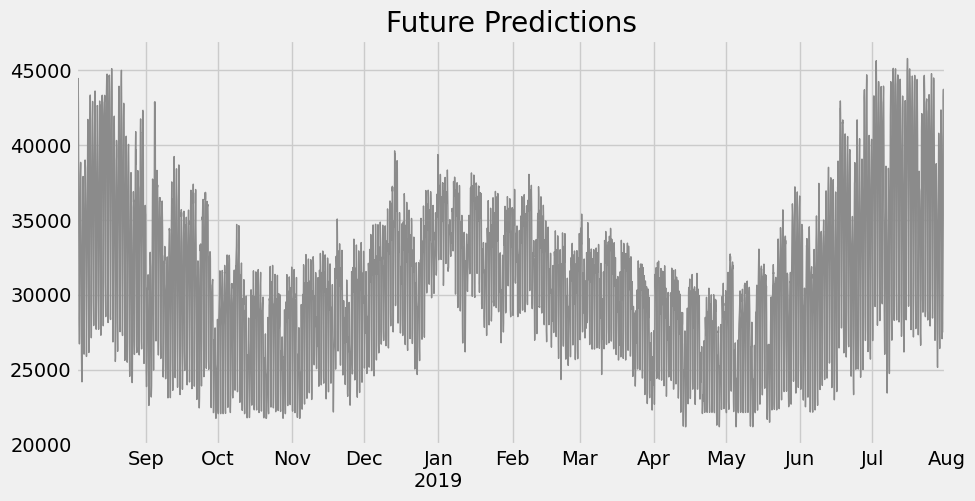

In [44]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [45]:
reg.save_model('model.json')

In [46]:
!ls -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


<Axes: title={'center': 'Future Predictions'}>

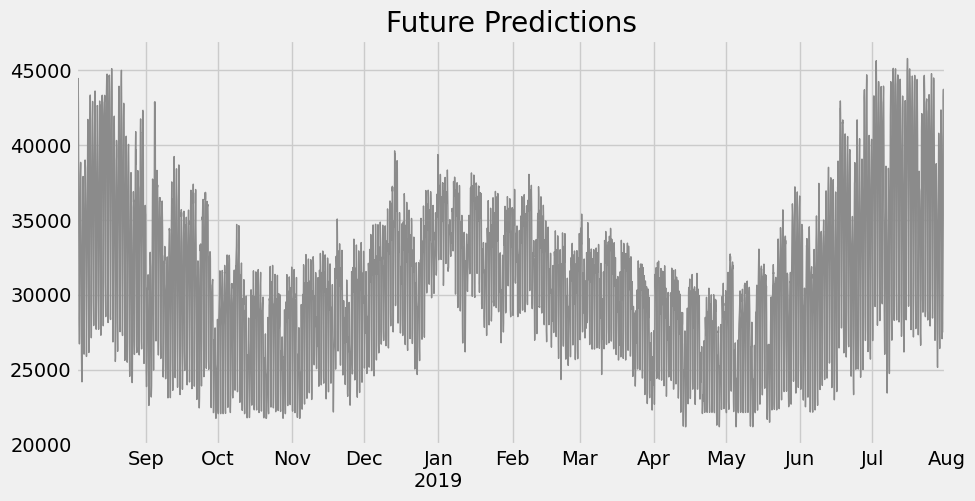

In [47]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')